In [2]:
import tensorflow as tf
import random
import os
import glob
import cv2
import numpy as np
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.models import save_model
from sklearn.model_selection import train_test_split
import h5py
import shutil
from lime import lime_image

In [5]:
current_dir = os.getcwd()
data_folder = os.path.join(current_dir,"Data")

In [6]:
real_paths = glob.glob(os.path.join(data_folder,"Real","*mp4"))
fake_paths = glob.glob(os.path.join(data_folder,"Fake","*mp4"))

In [7]:
image_size=(256,256)
channels = 3

def video_frames(path,size,n_frames=10):
    
    
    filename = os.path.basename(path).split(".")[0]
    folder = path.replace(os.path.basename(path),"")
    
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    for i in range(n_frames):
        
        
        
        randomFrameNumber=random.randint(0, frame_count)
        frames.append(randomFrameNumber)
    
    
    #print(frames)
    
    for frame_num in frames:
        
        capture.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        ret, frame = capture.read()
        
        if not ret:
            break
            
            
        
        frame = cv2.resize(frame,size)
        frame = cv2.imwrite(folder + filename + "_" + str(frame_num) + ".jpg",frame)
        
    
    
    
    

In [4]:
real_images = [video_frames(path,image_size) for path in real_paths]
fake_images = [video_frames(path,image_size) for path in fake_paths]

NameError: name 'real_paths' is not defined

In [39]:
#real_images = np.array(real_images)
#fake_images = np.array(fake_images)

In [40]:
#images = np.concatenate((real_images,fake_images),axis=0)

In [41]:
#y_real = np.zeros(100)
#y_fake = np.ones(100)

#y = np.concatenate((y_real,y_fake),axis=0)

In [42]:
#Images_train,Images_test,y_train,y_test = train_test_split(images,y,test_size = 0.2, random_state = 10)

In [154]:
#dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(data_folder,target_size=(256,256),batch_size=1,class_mode="binary")

Found 63434 images belonging to 2 classes.


In [91]:
class Classifier:
    
    def __init__():
        
        self.model = 0
        
    def predict(self,x):
        
        return self.model.predict(x,verbose = 0)
    
    def get_accuracy(self,x,y):
        
        return self.model.test_on_batch(x,y)
    
    def fit(self,x,y):
        
        return self.model.train_on_batch(x,y)
    
    def load(self,path):
        
        self.model.load_weights(path)

In [92]:
class Meso4(Classifier):
    
    def __init__(self,learning_rate = 0.001):
        
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,loss = "mean_squared_error",metrics = ["accuracy"])
        
    def init_model(self):
        
        x = Input(shape = (image_size[0],image_size[1],channels))
        
        x1 = Conv2D(8,(3,3),padding="same",activation="relu")(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2,2),padding="same")(x1)
        
        x2 = Conv2D(8,(5,5),padding="same",activation="relu")(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2,2),padding="same")(x2)
        
        x3 = Conv2D(16,(5,5),padding="same",activation="relu")(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2,2),padding="same")(x3)
        
        x4 = Conv2D(16,(5,5),padding="same",activation="relu")(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4,4),padding="same")(x4)

        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = Dropout(0.5)(y)
        y = Dense(1,activation = "sigmoid")(y)
        
        return Model(inputs = x, outputs = y)

In [93]:
meso = Meso4()
meso.load(os.path.join(current_dir,"Meso4_DF"))

In [155]:
generator.class_indices

{'Fake': 0, 'Real': 1}

In [156]:
X, y = generator.next()

In [157]:
meso.predict(X)[0][0]


0.9994536

In [158]:
int(y[0])

0

In [159]:
round(meso.predict(X)[0][0]) == y[0]

False

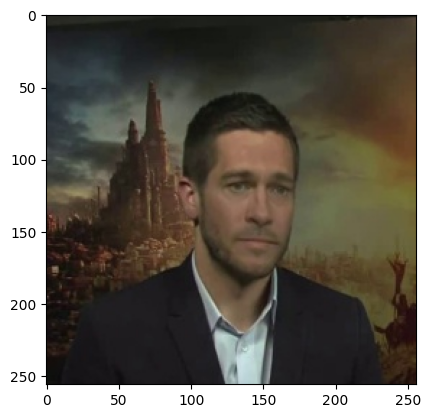

In [175]:
plt.imshow(np.squeeze(X))

In [58]:
true_Positive = []
true_Positive_pred = []

true_Negative = []
true_Negative_pred = []

false_Positive = []
false_Positive_pred = []

false_Negative = []
false_Negative_pred = []

for i in range(1000):
    
    X,y = generator.next()
    pred = meso.predict(X)[0][0]
    
    if round(pred) == y[0] and y[0] == 1:
        true_Positive.append(X)
        true_Positive_pred.append(pred)
        
    elif round(pred) == y[0] and y[0] == 0:
        true_Negative.append(X)
        true_Negative_pred.append(pred)
        
    elif y[0] == 0:
        false_Negative.append(X)
        false_Negative_pred.append(pred)
        
    else:
        false_Positive.append(X)
        false_Positive_pred.append(pred)
        

In [47]:


def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(1, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return



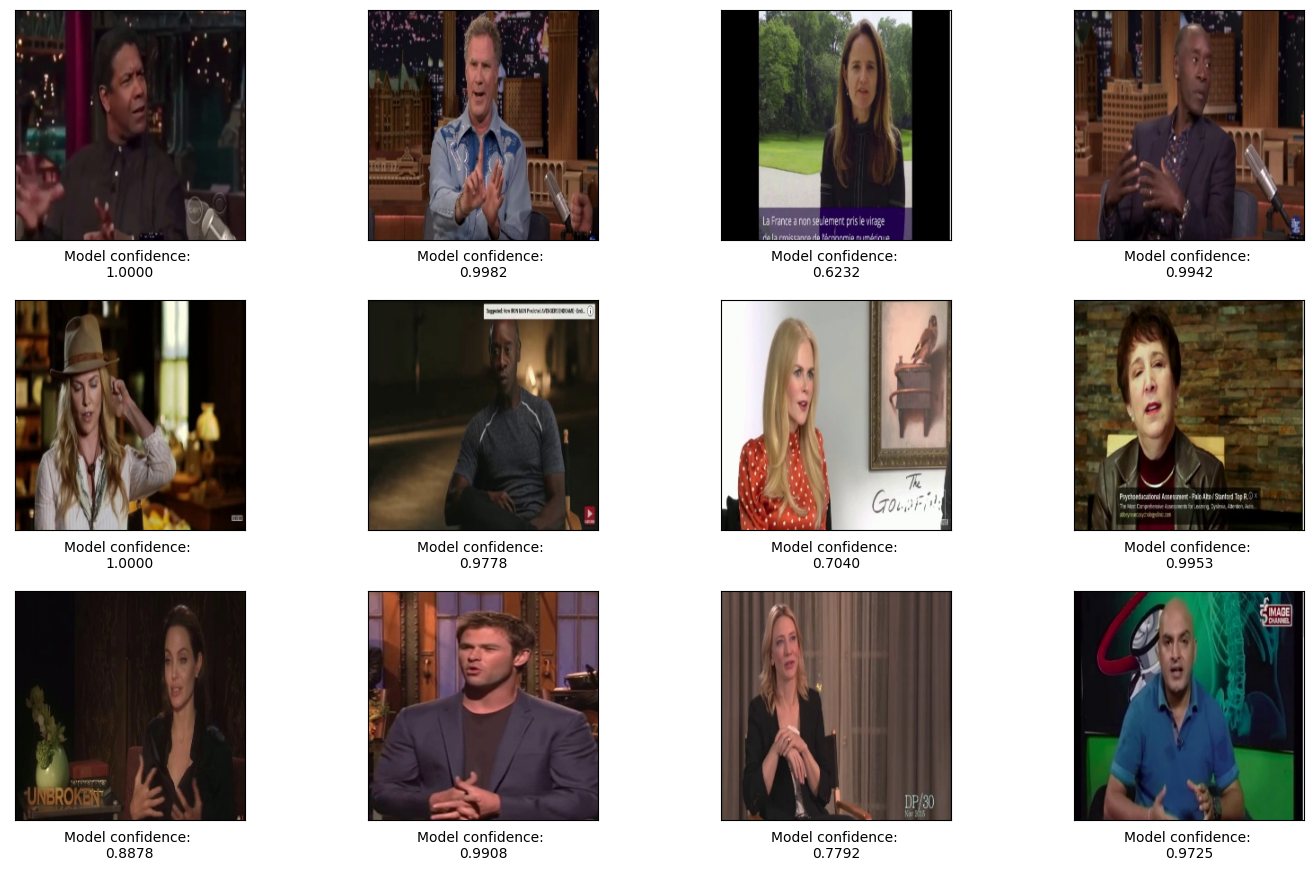

In [161]:
plotter(true_Positive,true_Positive_pred)

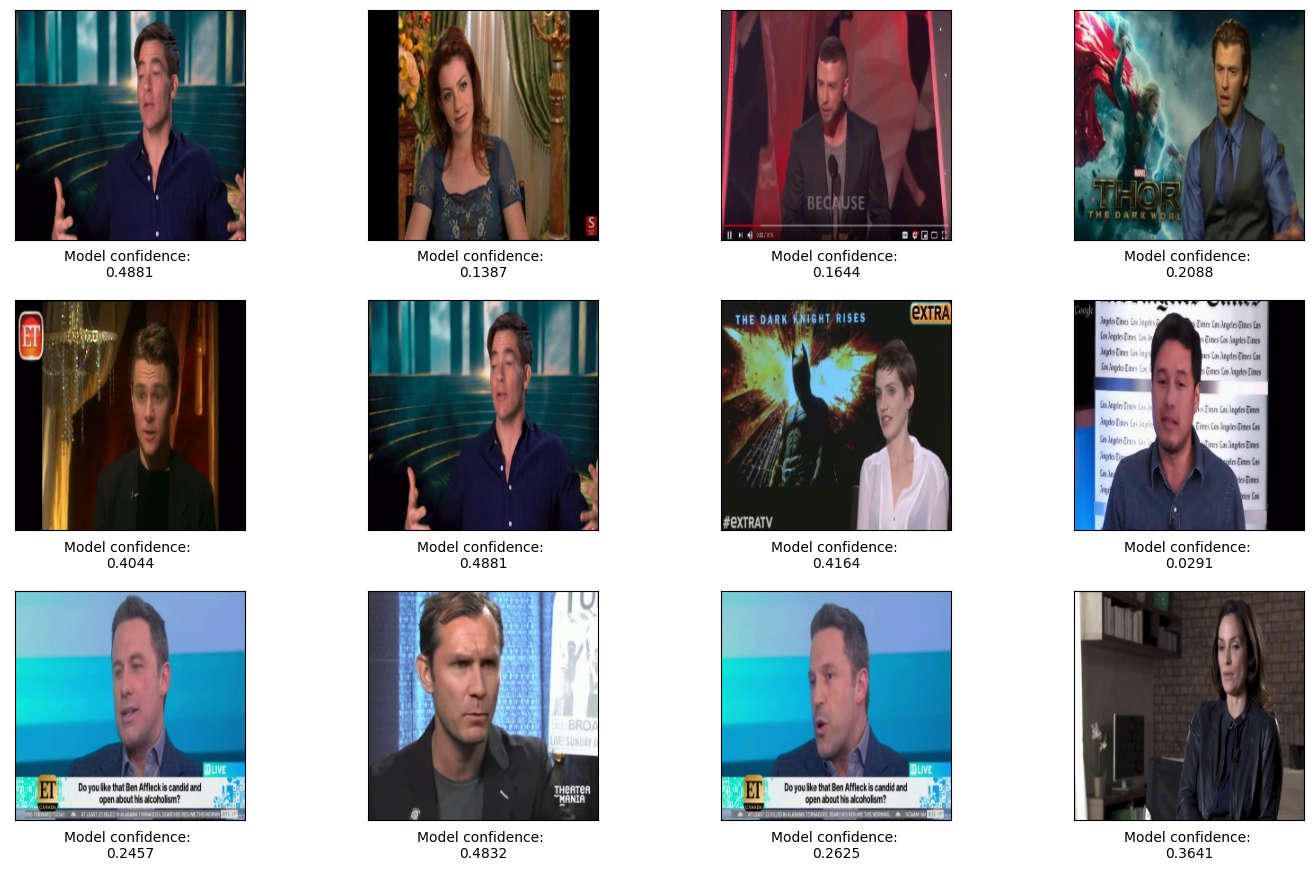

In [162]:
plotter(true_Negative,true_Negative_pred)

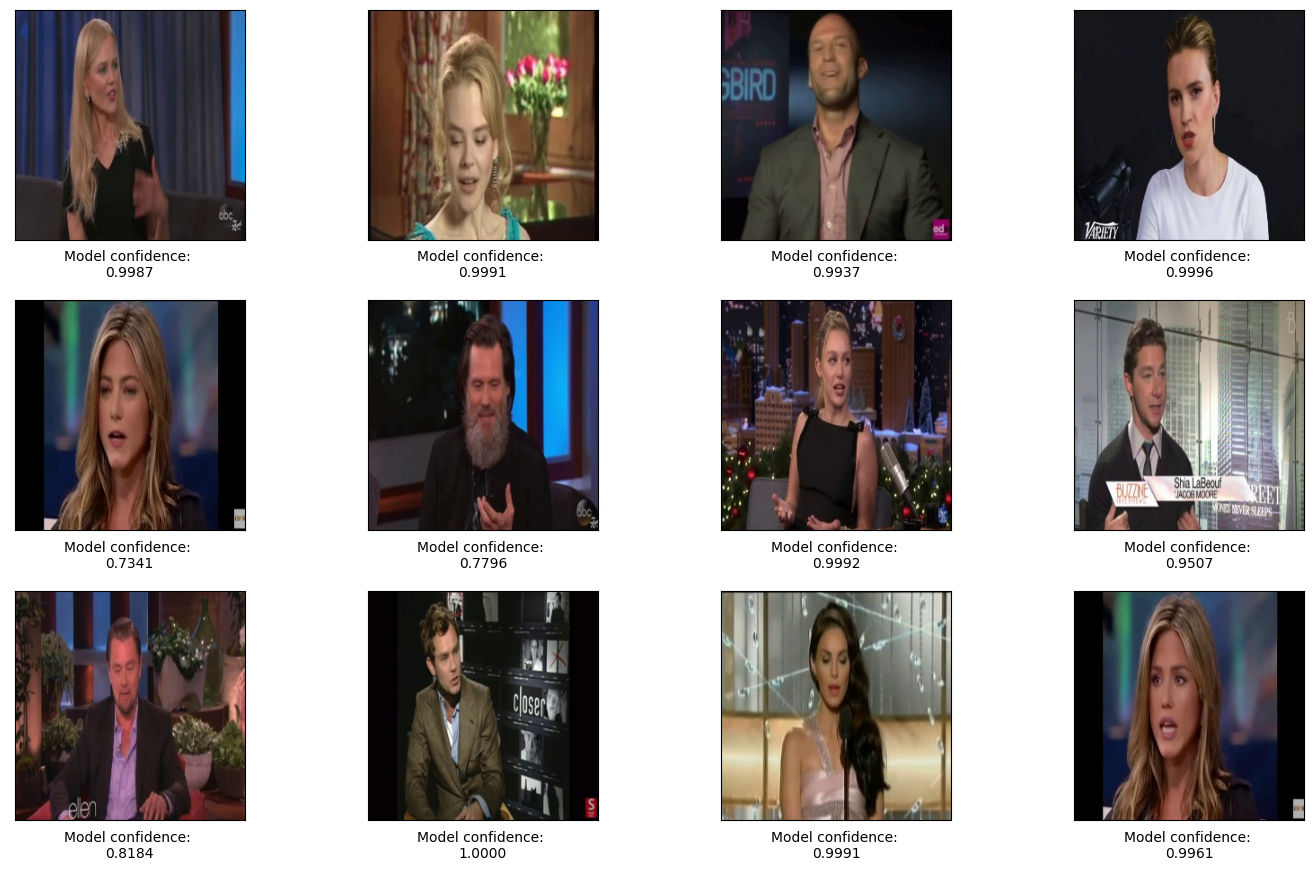

In [163]:
plotter(false_Negative,false_Negative_pred)

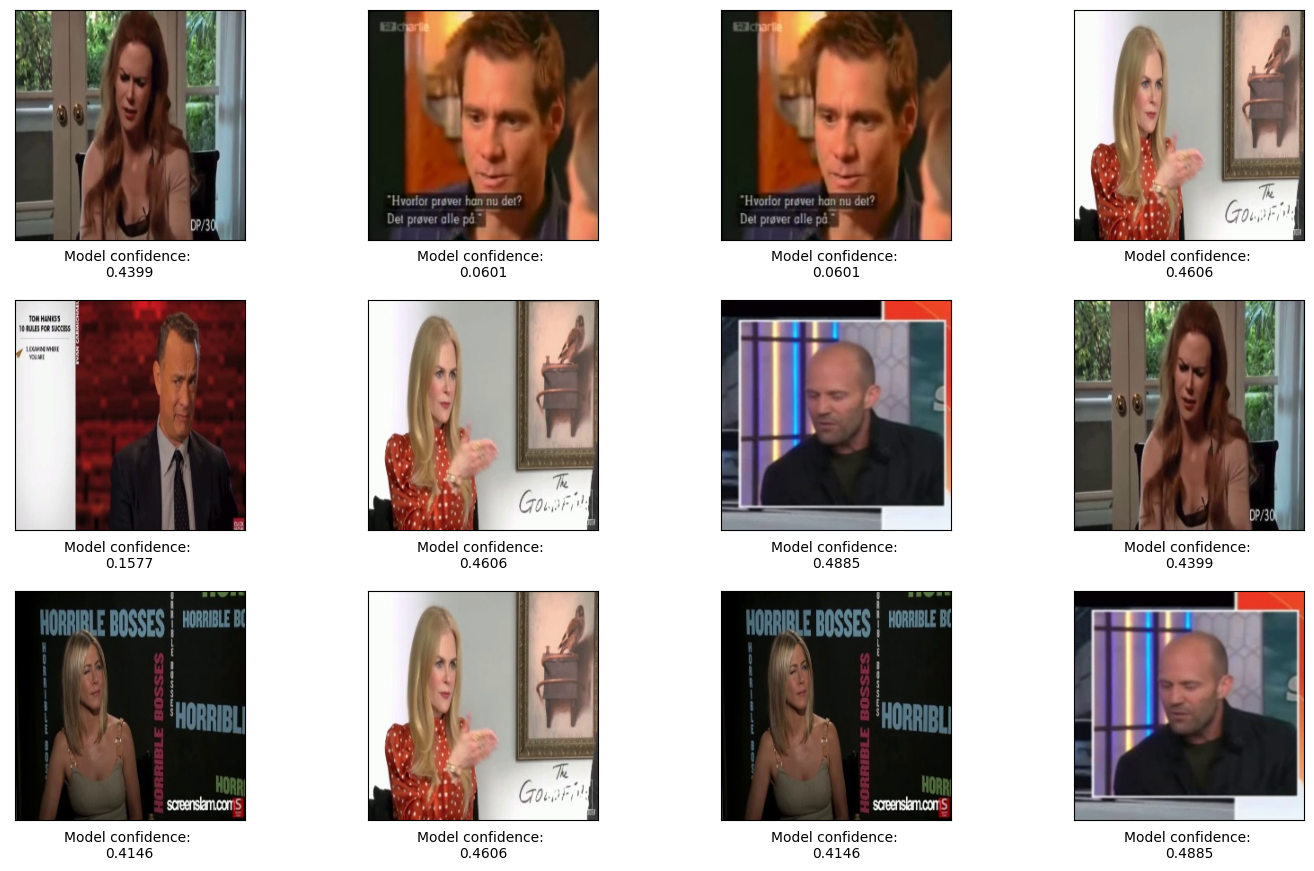

In [164]:
plotter(false_Positive,false_Positive_pred)

In [189]:
from lime import lime_image

In [191]:
explainer = lime_image.LimeImageExplainer()

In [193]:
explanation = explainer.explain_instance(image, meso.predict(X[0][0]), top_labels=5, hide_color=0, num_samples=1000)

InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 4
	 [[{{node model_1/conv2d_4/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_predict_function_89556]